### **Introducción**

El presente notebook tiene como objetivo comparar en similares condiciones el desempeño de cuatro modelos de elección discreta: **ResLogit**, **TasteNet**, **LearningMNL** y **RUMnet**, utilizando la librería **Choice Learn** y el dataset **Swissmetro**

#### **Librerías utilizadas**
- **Choice Learn**: Librería especializada en modelos de elección discreta, que proporciona implementaciones de modelos clásicos y basados en redes neuronales.
- **NumPy**: Para operaciones numéricas y manipulación de arrays.
- **Pandas**: Para la manipulación y preprocesamiento de datos.
- **Matplotlib**: Para la visualización de resultados.
- **TensorFlow**: Como backend para los modelos basados en redes neuronales.
- **Scikit-learn**: Para la implementación de validación cruzada agrupada (`GroupKFold`).

#### **Condiciones para la experimentación**
1. **Dataset**: Se utiliza el dataset **Swissmetro**, un conjunto de datos clásico en modelos de elección discreta, que contiene información sobre las preferencias de los usuarios entre tren, metro suizo y coche.
2. **Preprocesamiento**: Los datos se normalizan y transforman para garantizar que sean compatibles con los modelos.
3. **Validación cruzada**: Se utiliza una validación cruzada de 5 folds agrupada por usuario (`GroupKFold`) para garantizar que las respuestas de un mismo usuario no se dividan entre entrenamiento y prueba.
4. **Métricas de evaluación**: Se utiliza la pérdida de log-verosimilitud negativa como métrica principal para comparar el rendimiento de los modelos.
5. **Hardware**: El experimento se ejecuta en CPU para garantizar consistencia en los resultados.

#### **Flujo del código**
1. **Carga y preprocesamiento de datos**: Se cargan los datos de Swissmetro y se realizan transformaciones como normalización y creación de variables adicionales.
2. **Configuración de modelos**: Se definen los hiperparámetros y configuraciones específicas para cada modelo.
3. **Entrenamiento y evaluación**: Se entrena cada modelo utilizando validación cruzada y se evalúa su rendimiento en términos de pérdida de entrenamiento y prueba.
4. **Visualización de resultados**: Se grafican las pérdidas de entrenamiento y prueba para cada modelo, y se comparan los resultados promedio.

In [15]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GroupKFold
from choice_learn.data import ChoiceDataset
from choice_learn.models import ResLogit, TasteNet, LearningMNL, RUMnet

# Deshabilitar GPU para consistencia
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Cargar datos
train_df = pd.read_csv("https://raw.githubusercontent.com/BSifringer/EnhancedDCM/refs/heads/master/ready_example/swissmetro_paper/swissmetro_train.dat", sep="\t")
test_df = pd.read_csv("https://raw.githubusercontent.com/BSifringer/EnhancedDCM/refs/heads/master/ready_example/swissmetro_paper/swissmetro_test.dat", sep="\t")

In [10]:
def preprocess_data(df):
    df = df.loc[(df.CAR_AV == 1) & (df.SM_AV == 1) & (df.TRAIN_AV == 1)]
    df[["TRAIN_TT", "SM_TT", "CAR_TT"]] /= 100.0
    df[["TRAIN_HE", "SM_HE"]] /= 100.0
    df["train_free_ticket"] = df.GA.apply(lambda x: 1 if x == 1 else 0)
    df["sm_free_ticket"] = df.GA.apply(lambda x: 1 if x == 1 else 0)
    df["TRAIN_travel_cost"] = (df["TRAIN_CO"] * (1 - df["train_free_ticket"])) / 100
    df["SM_travel_cost"] = (df["SM_CO"] * (1 - df["sm_free_ticket"])) / 100
    df["CAR_travel_cost"] = df["CAR_CO"] / 100
    df["CHOICE"] -= 1
    # Convertir todas las columnas relevantes a float32 para L-MNL
    for col in df.select_dtypes(include=["float64", "int64"]).columns:
        df[col] = df[col].astype(np.float32)
    return df

train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

# Crear ChoiceDataset
def create_dataset(df):
    return ChoiceDataset.from_single_wide_df(
        df=df,
        choices_column="CHOICE",
        items_id=["TRAIN", "SM", "CAR"],
        shared_features_columns=["GA", "AGE", "SM_SEATS", "LUGGAGE", "PURPOSE", "FIRST", "TICKET", "WHO", "MALE", "INCOME", "ORIGIN", "DEST"],
        items_features_suffixes=["TT", "travel_cost", "HE"],
        choice_format="items_index"
    )

full_dataset = create_dataset(pd.concat([train_df, test_df]))
customers_id = np.concatenate([train_df["ID"].values, test_df["ID"].values])


C:\Users\nicol\AppData\Local\Temp\ipykernel_22628\1575602693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["TRAIN_TT", "SM_TT", "CAR_TT"]] /= 100.0
C:\Users\nicol\AppData\Local\Temp\ipykernel_22628\1575602693.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["TRAIN_HE", "SM_HE"]] /= 100.0
C:\Users\nicol\AppData\Local\Temp\ipykernel_22628\1575602693.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [11]:
# Parámetros comunes
n_items = 3
n_items_features = 3  # TT, travel_cost, HE
n_shared_features = 12  # GA, AGE, SM_SEATS, LUGGAGE, PURPOSE, FIRST, TICKET, WHO, MALE, INCOME, ORIGIN, DEST

# Configuración ResLogit
reslogit_args = {
    "intercept": "item",
    "optimizer": "SGD",
    "lr": 1e-6,
    "epochs": 5
}

# Configuración TasteNet
tastenet_args = {
    "taste_net_layers": [],
    "taste_net_activation": "relu",
    "items_features_by_choice_parametrization": [
        [-1., "-exp", "-exp"],  # Características para el tren (3 características)
        [-1., "-exp", "-exp"],  # Características para el metro suizo (3 características)
        [-1., "-exp", 0.]       # Características para el coche (3 características)
    ],
    "optimizer": "Adam",
    "epochs": 4,
    "lr": 0.001,
    "batch_size": 32
}

# Configuración LearningMNL
learningmnl_args = {
    "optimizer": "Adam",
    "lr": 0.005,
    "nn_features": ['PURPOSE', 'FIRST', 'TICKET', 'WHO', 'MALE', 'INCOME', 'ORIGIN', 'DEST'],
    "nn_layers_widths": [200],
    "epochs": 5,
    "batch_size": 32
}


# Configuración RUMnet
rumnet_args = {
    "num_products_features": n_items_features,
    "num_customer_features": n_shared_features,
    "width_eps_x": 20,
    "depth_eps_x": 5,
    "heterogeneity_x": 10,
    "width_eps_z": 20,
    "depth_eps_z": 5,
    "heterogeneity_z": 10,
    "width_u": 20,
    "depth_u": 5,
    "optimizer": "Adam",
    "lr": 0.0002,
    "epochs": 5,
    "batch_size": 32,
    "tol": 0,
}


In [12]:
def train_model(model_name, train_data, test_data):
    if model_name == "ResLogit":
        model = ResLogit(n_layers=4, **reslogit_args)
        model.instantiate(n_items=n_items, n_shared_features=n_shared_features, n_items_features=n_items_features)
    elif model_name == "TasteNet":
        model = TasteNet(**tastenet_args)
    elif model_name == "LearningMNL":
        model = LearningMNL(**learningmnl_args)
        model.add_shared_coefficient(feature_name="TT", items_indexes=[0, 1, 2])
        model.add_shared_coefficient(feature_name="travel_cost", items_indexes=[0, 1, 2])
        model.add_shared_coefficient(feature_name="HE", items_indexes=[0, 1])
        model.add_shared_coefficient(feature_name="GA", items_indexes=[0, 1])
        model.add_shared_coefficient(feature_name="AGE", items_indexes=[0])
        model.add_shared_coefficient(feature_name="LUGGAGE", items_indexes=[2])
        model.add_shared_coefficient(feature_name="SM_SEATS", items_indexes=[1])
        model.add_coefficients(feature_name="intercept", items_indexes=[1, 2])
    elif model_name == "RUMnet":
        model = RUMnet(**rumnet_args)
        model.instantiate()
    
    history = model.fit(train_data, val_dataset=test_data)
    train_loss = model.evaluate(train_data)
    test_loss = model.evaluate(test_data)
    return history, train_loss, test_loss

In [13]:
gkf = GroupKFold(n_splits=5)
results = {model: {"train_loss": [], "test_loss": []} for model in ["ResLogit", "TasteNet", "LearningMNL", "RUMnet"]}

for fold, (train_idx, test_idx) in enumerate(gkf.split(full_dataset, groups=customers_id)):
    print(f"\n=== Fold {fold + 1}/5 ===")
    train_data = full_dataset[train_idx]
    test_data = full_dataset[test_idx]
    
    for model_name in results.keys():
        print(f"\nEntrenando {model_name}...")
        start_time = time.time()  
        history, train_loss, test_loss = train_model(model_name, train_data, test_data)
        end_time = time.time()  
        
        execution_time = end_time - start_time
        print(f"Tiempo de ejecución para {model_name}: {execution_time:.2f} segundos")
        
        results[model_name]["train_loss"].append(train_loss)
        results[model_name]["test_loss"].append(test_loss)
        results[model_name]["execution_time"].append(execution_time)


=== Fold 1/5 ===

Entrenando ResLogit...


Epoch 4 Train Loss 0.8351: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]



Entrenando TasteNet...


Epoch 3 Train Loss 0.8703: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]



Entrenando LearningMNL...


Epoch 4 Train Loss 0.7238: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]



Entrenando RUMnet...


Epoch 4 Train Loss 0.7273: 100%|██████████| 5/5 [03:37<00:00, 43.55s/it] 



=== Fold 2/5 ===

Entrenando ResLogit...


Epoch 4 Train Loss 0.8426: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]



Entrenando TasteNet...


Epoch 3 Train Loss 3.8955: 100%|██████████| 4/4 [00:19<00:00,  4.77s/it]



Entrenando LearningMNL...


Epoch 4 Train Loss 0.7408: 100%|██████████| 5/5 [00:30<00:00,  6.10s/it]



Entrenando RUMnet...


Epoch 4 Train Loss 0.7287: 100%|██████████| 5/5 [04:41<00:00, 56.38s/it] 



=== Fold 3/5 ===

Entrenando ResLogit...


Epoch 4 Train Loss 0.8399: 100%|██████████| 5/5 [00:13<00:00,  2.70s/it]



Entrenando TasteNet...


Epoch 3 Train Loss 0.8755: 100%|██████████| 4/4 [00:12<00:00,  3.06s/it]



Entrenando LearningMNL...


Epoch 4 Train Loss 0.7359: 100%|██████████| 5/5 [00:36<00:00,  7.38s/it]



Entrenando RUMnet...


Epoch 4 Train Loss 0.7151: 100%|██████████| 5/5 [04:26<00:00, 53.37s/it] 



=== Fold 4/5 ===

Entrenando ResLogit...


Epoch 4 Train Loss 0.8430: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]



Entrenando TasteNet...


Epoch 3 Train Loss 0.8632: 100%|██████████| 4/4 [00:13<00:00,  3.37s/it] 



Entrenando LearningMNL...


Epoch 4 Train Loss 0.7478: 100%|██████████| 5/5 [00:29<00:00,  5.85s/it]



Entrenando RUMnet...


Epoch 4 Train Loss 0.7469: 100%|██████████| 5/5 [04:53<00:00, 58.62s/it] 



=== Fold 5/5 ===

Entrenando ResLogit...


Epoch 4 Train Loss 0.8423: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]



Entrenando TasteNet...


Epoch 3 Train Loss 0.8409: 100%|██████████| 4/4 [00:15<00:00,  3.82s/it] 



Entrenando LearningMNL...


Epoch 4 Train Loss 0.7482: 100%|██████████| 5/5 [00:33<00:00,  6.76s/it]



Entrenando RUMnet...


Epoch 4 Train Loss 0.7354: 100%|██████████| 5/5 [04:39<00:00, 55.95s/it] 


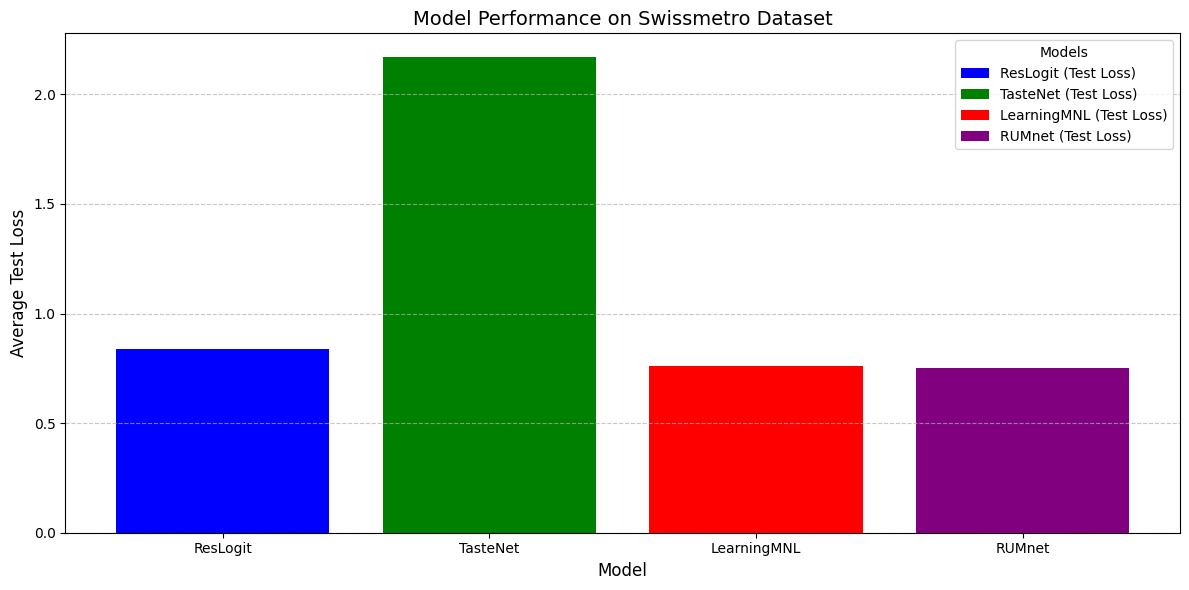


Detailed Model Results:
ResLogit:
  - Average Train Loss:   0.8365
  - Average Test Loss:    0.8402
TasteNet:
  - Average Train Loss:   2.0827
  - Average Test Loss:    2.1698
LearningMNL:
  - Average Train Loss:   0.7270
  - Average Test Loss:    0.7602
RUMnet:
  - Average Train Loss:   0.7241
  - Average Test Loss:    0.7527


In [18]:
# Plot configuration
plt.figure(figsize=(12, 6))
colors = {"ResLogit": "blue", "TasteNet": "green", "LearningMNL": "red", "RUMnet": "purple"}

# Bar chart of average test loss
for model_name, metrics in results.items():
    avg_test_loss = np.mean(metrics["test_loss"])
    plt.bar(model_name, avg_test_loss, color=colors[model_name], label=f"{model_name} (Test Loss)")

plt.xlabel("Model", fontsize=12)
plt.ylabel("Average Test Loss", fontsize=12)
plt.title("Model Performance on Swissmetro Dataset", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Models", fontsize=10)
plt.tight_layout()
plt.show()

# Print detailed numerical results
print("\nDetailed Model Results:")
for model_name, metrics in results.items():
    avg_train_loss = np.mean(metrics["train_loss"])
    avg_test_loss = np.mean(metrics["test_loss"])
    #avg_execution_time = np.mean(metrics["execution_time"])
    print(f"{model_name}:")
    print(f"  - Average Train Loss:   {avg_train_loss:.4f}")
    print(f"  - Average Test Loss:    {avg_test_loss:.4f}")
    #print(f"  - Average Execution Time: {avg_execution_time:.2f} seconds\n")
